In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely as shy
from shapely.ops import nearest_points
from shapely.geometry import Point, MultiPoint
import fiona
from fiona.crs import from_epsg
from scipy.spatial import cKDTree
import numpy as np
import osmnx as ox
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

pd.options.display.max_rows = 4
%matplotlib inline
import os
os.environ["PROJ_LIB"] = "C:\ProgramData\Anaconda3\Library\share" #window

In [2]:
#Filepaths
work = r"D:"
laptop = r"C:\Users\jerem"
origin = work

In [3]:
fp = r"\Box Sync\Policy Evaluation\working_data\analytical_panel_shapefile\analytical_panel_qt_shapefile_crosssec_thiessen_polygons.shp"
df1 = gpd.read_file(origin+fp)

In [4]:
df1.head(3)

,collision_,personsinj,pedestrian,cyclistinj,motoristin,bronx,brooklyn,manhattan,queens,statenisla,...,flag_senio,flag_prior,flag_schoo,flag_stree,quarter,year,intersecti,y,x,geometry
0,6,1,1,0,0,0,0,1,0,0,...,1,1,0,0,3,2012,1,199793.6093,986336.1490,"POLYGON ((986150.2933460365 199702.6472557705,..."
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,3,2012,2,202206.1619,982769.3310,"POLYGON ((982610.6377425257 202090.8501983829,..."
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,3,2012,3,201790.0942,982805.6184,"POLYGON ((982528.6632446027 201736.7410315565,..."


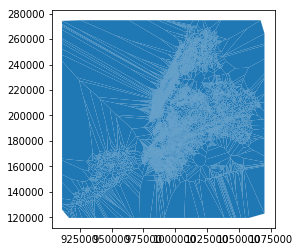

In [5]:
df1.plot()

In [6]:
df1.crs
df1 = df1.to_crs({'init': 'epsg:4326'})

In [7]:
fp = r"\Box Sync\Policy Evaluation\input_data\nyc_boroughs_2263\nyc_boroughs_2263.shp"
df2 = gpd.read_file(origin+fp)

In [8]:
df2.head()

,bcode,bname,name,namelsad,geometry
0,36005,Bronx,Bronx,Bronx County,(POLYGON ((1008982.068976385 272752.8735210547...
1,36047,Brooklyn,Kings,Kings County,(POLYGON ((978869.3811487257 186863.7807399245...
...,...,...,...,...,...
3,36081,Queens,Queens,Queens County,(POLYGON ((1026830.772887008 155435.7100568501...
4,36085,Staten Island,Richmond,Richmond County,(POLYGON ((930721.1281812892 156627.9162643671...


In [9]:
df2.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [10]:
# Reproeject LPIS shapefile to EPSG 4326: WGS84
df2 = df2.to_crs({'init': 'epsg:4326'})

In [11]:
df2.crs

{'init': 'epsg:4326'}

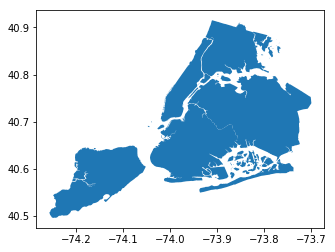

In [12]:
df2.plot()

In [13]:
## Pull out Manhattan
#manhattan = df2['bname'] == "Manhattan"
whitelist = pd.Series('Manhattan')
manhattan = df2[df2['bname'].isin(whitelist)]

In [14]:
manhattan.columns

Index(['bcode', 'bname', 'name', 'namelsad', 'geometry'], dtype='object')

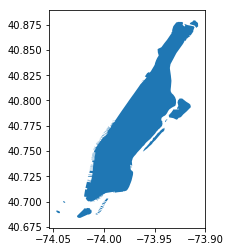

In [15]:
manhattan.plot()

In [16]:
manhattan.type
manhattan_explode = manhattan.explode()

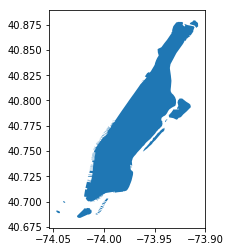

In [17]:
manhattan_explode.plot()

In [18]:
df2.crs = df1.crs
manhattan_explode.crs = df1.crs

In [19]:
df2.count()

bcode       5
bname       5
           ..
namelsad    5
geometry    5
Length: 5, dtype: int64

In [20]:
df2_explode = df2.explode()

In [21]:
df2_explode.count()

bcode       85
bname       85
            ..
namelsad    85
geometry    85
Length: 5, dtype: int64

In [22]:
# Intersection
intersection = gpd.overlay(df1, df2_explode, how='intersection')

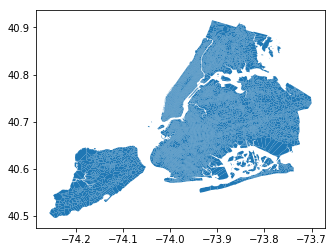

In [23]:
intersection.plot()

In [24]:
intersection.count()

collision_    13315
personsinj    13315
              ...  
namelsad      13315
geometry      13315
Length: 36, dtype: int64

In [25]:
# Intersection of Manhattan only
manhattan_intersection = gpd.overlay(df1, manhattan_explode, how='intersection')

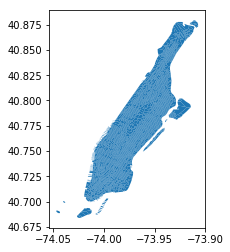

In [26]:
manhattan_intersection.plot()

In [27]:
manhattan_intersection.count()

collision_    2833
personsinj    2833
              ... 
namelsad      2833
geometry      2833
Length: 36, dtype: int64

### Problem: Smaller islands that intersect with the theissen polygons
Do a spatial match each polygon should have a point on it.

In [28]:
fp = r"\Box Sync\Policy Evaluation\working_data\analytical_panel_shapefile\analytical_panel_qt_shapefile_crosssec.shp"
df3 = gpd.read_file(origin+fp)

In [29]:
df3.count()

collision_    12987
personsinj    12987
              ...  
x             12987
geometry      12987
Length: 32, dtype: int64

In [30]:
df3.crs

{'proj': 'lcc',
 'lat_1': 41.03333333333333,
 'lat_2': 40.66666666666666,
 'lat_0': 40.16666666666666,
 'lon_0': -74,
 'x_0': 300000.0000000001,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [31]:
# Reproeject LPIS shapefile to EPSG 4326: WGS84
df3 = df3.to_crs({'init': 'epsg:4326'})

In [32]:
intersection_with_df3 = gpd.sjoin(intersection,df3, how='inner', op='intersects')

manhattan_intersection_with_df3 = gpd.sjoin(manhattan_intersection,df3, how='inner', op='intersects')

In [33]:
intersection_with_df3.head(5)

,collision__left,personsinj_left,pedestrian_left,cyclistinj_left,motoristin_left,bronx_left,brooklyn_left,manhattan_left,queens_left,statenisla_left,...,bike_rou_1_right,flag_senio_right,flag_prior_right,flag_schoo_right,flag_stree_right,quarter_right,year_right,intersecti_right,y_right,x_right
1,6,1,1,0,0,0,0,1,0,0,...,1,1,1,0,0,3,2012,1,199793.6093,986336.1490
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,3,2012,2,202206.1619,982769.3310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,3,2012,4,201529.9618,982812.2555
9,5,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,3,2012,5,201226.1097,982816.3956


In [34]:
manhattan_intersection_with_df3.head(3)

,collision__left,personsinj_left,pedestrian_left,cyclistinj_left,motoristin_left,bronx_left,brooklyn_left,manhattan_left,queens_left,statenisla_left,...,bike_rou_1_right,flag_senio_right,flag_prior_right,flag_schoo_right,flag_stree_right,quarter_right,year_right,intersecti_right,y_right,x_right
0,6,1,1,0,0,0,0,1,0,0,...,1,1,1,0,0,3,2012,1,199793.6093,986336.1490
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,3,2012,2,202206.1619,982769.3310
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,3,2012,3,201790.0942,982805.6184


In [35]:
intersection_with_df3.count()
#It is suppose to be 12,987, but we only have 12983

collision__left    12983
personsinj_left    12983
                   ...  
y_right            12983
x_right            12983
Length: 68, dtype: int64

In [36]:
manhattan_intersection_with_df3.count()

collision__left    2736
personsinj_left    2736
                   ... 
y_right            2736
x_right            2736
Length: 68, dtype: int64

In [37]:
manhattan_intersection_with_df3.columns

Index(['collision__left', 'personsinj_left', 'pedestrian_left',
       'cyclistinj_left', 'motoristin_left', 'bronx_left', 'brooklyn_left',
       'manhattan_left', 'queens_left', 'statenisla_left', 'distance_t_left',
       'distance_1_left', 'distance_2_left', 'distance_3_left',
       'distance_4_left', 'distance_5_left', 'flag_left__left',
       'flag_lef_1_left', 'flag_LPIS__left', 'flag_LPIS_left',
       'bike_route_left', 'bike_rou_1_left', 'flag_senio_left',
       'flag_prior_left', 'flag_schoo_left', 'flag_stree_left', 'quarter_left',
       'year_left', 'intersecti_left', 'y_left', 'x_left', 'bcode', 'bname',
       'name', 'namelsad', 'geometry', 'index_right', 'collision__right',
       'personsinj_right', 'pedestrian_right', 'cyclistinj_right',
       'motoristin_right', 'bronx_right', 'brooklyn_right', 'manhattan_right',
       'queens_right', 'statenisla_right', 'distance_t_right',
       'distance_1_right', 'distance_2_right', 'distance_3_right',
       'distance_4_r

In [38]:
intersection_with_df3.columns

Index(['collision__left', 'personsinj_left', 'pedestrian_left',
       'cyclistinj_left', 'motoristin_left', 'bronx_left', 'brooklyn_left',
       'manhattan_left', 'queens_left', 'statenisla_left', 'distance_t_left',
       'distance_1_left', 'distance_2_left', 'distance_3_left',
       'distance_4_left', 'distance_5_left', 'flag_left__left',
       'flag_lef_1_left', 'flag_LPIS__left', 'flag_LPIS_left',
       'bike_route_left', 'bike_rou_1_left', 'flag_senio_left',
       'flag_prior_left', 'flag_schoo_left', 'flag_stree_left', 'quarter_left',
       'year_left', 'intersecti_left', 'y_left', 'x_left', 'bcode', 'bname',
       'name', 'namelsad', 'geometry', 'index_right', 'collision__right',
       'personsinj_right', 'pedestrian_right', 'cyclistinj_right',
       'motoristin_right', 'bronx_right', 'brooklyn_right', 'manhattan_right',
       'queens_right', 'statenisla_right', 'distance_t_right',
       'distance_1_right', 'distance_2_right', 'distance_3_right',
       'distance_4_r

In [41]:
save_out = intersection_with_df3[['collision__left', 'personsinj_left', 'pedestrian_left',
       'cyclistinj_left', 'motoristin_left', 'bronx_left', 'brooklyn_left',
       'manhattan_left', 'queens_left', 'statenisla_left', 'distance_t_left',
       'distance_1_left', 'distance_2_left', 'distance_3_left',
       'distance_4_left', 'distance_5_left', 'flag_left__left',
       'flag_lef_1_left', 'flag_LPIS__left', 'flag_LPIS_left',
       'bike_route_left', 'bike_rou_1_left', 'flag_senio_left',
       'flag_prior_left', 'flag_schoo_left', 'flag_stree_right', 'quarter_left', 'year_left',
       'intersecti_left', 'y_left', 'x_left', 'geometry']]
    
fp = r"\Box Sync\Policy Evaluation\working_data\analytical_panel_shapefile\analytical_panel_qt_shapefile_crosssec_thiessen_polygons_clipped.shp"
save_out.to_file(origin+fp)

In [42]:
save_out = manhattan_intersection_with_df3[['collision__left', 'personsinj_left', 'pedestrian_left',
       'cyclistinj_left', 'motoristin_left', 'bronx_left', 'brooklyn_left',
       'manhattan_left', 'queens_left', 'statenisla_left', 'distance_t_left',
       'distance_1_left', 'distance_2_left', 'distance_3_left',
       'distance_4_left', 'distance_5_left', 'flag_left__left',
       'flag_lef_1_left', 'flag_LPIS__left', 'flag_LPIS_left',
       'bike_route_left', 'bike_rou_1_left', 'flag_senio_left',
       'flag_prior_left', 'flag_schoo_left', 'flag_stree_right', 'quarter_left', 'year_left',
       'intersecti_left', 'y_left', 'x_left', 'geometry']]

fp = r"\Box Sync\Policy Evaluation\working_data\analytical_panel_shapefile\analytical_panel_qt_shapefile_crosssec_thiessen_polygons_clipped_manhattan.shp"
save_out.to_file(origin+fp)

In [43]:
save_out.columns

Index(['collision__left', 'personsinj_left', 'pedestrian_left',
       'cyclistinj_left', 'motoristin_left', 'bronx_left', 'brooklyn_left',
       'manhattan_left', 'queens_left', 'statenisla_left', 'distance_t_left',
       'distance_1_left', 'distance_2_left', 'distance_3_left',
       'distance_4_left', 'distance_5_left', 'flag_left__left',
       'flag_lef_1_left', 'flag_LPIS__left', 'flag_LPIS_left',
       'bike_route_left', 'bike_rou_1_left', 'flag_senio_left',
       'flag_prior_left', 'flag_schoo_left', 'flag_stree_right',
       'quarter_left', 'year_left', 'intersecti_left', 'y_left', 'x_left',
       'geometry'],
      dtype='object')